# Introduction

Integrate in time the vorticity equation.

Run the simple code first.

1. Then change to $Re=10$, $nx=11$, $dt=0.035$, $dpic=0.025$ and $tfinal=0.525$. The plot of the streamfunction should show the numerical instability. Decreasing $dt$ to 0.03 nearly stabilises the result at this $tfinal$, while $dt=0.025$ works to $tfinal=3.0$. This value of $dt$ is the marginal value, but that is for large grids, and small grids are slightly more stable. Best to work at $dt=0.2*Re*h*h$

1. The code first calculates the boundary conditions to first-order, and then extrapolates these results to apply the conditions to second-order. Use this second-order code. Change to  $Re=10$, $nx=11$, $dpic=0.1$ and $tfinal=1.0$ and $dt=0.02$. Find the value of $\omega(x=0.5,y=0.5,t=1.0)$. Now decrease $dt$ to 0.01, 0.005, 0.0025 and 0.001. Then with $nx=15$ try $dt$ = 0.01 (largest stable value), 0.005, 0.0025 and 0.001. Finally with $nx=21$ try $dt=$ 0.005 (largest stable value), 0.0025 and 0.001. Plot these results for $\psi(x=0.5,y=0.5,t=1.0)$ as a function of $dt$. **You could experiment by deleting the lines of the code that apply the boundary conditions at second-order.**

1. Now set $tfinal=3.0$, $dpic=0.1$ and $dt=0.2*Re*h*h$ and obtain $\omega(x=0.5,y=0.5,t)$ to find how long it takes the vorticity to attain a steady value within 4 significant figures. Compare your plots for the steady state of the streamfunction and the vorticity.

1. Gather results for different spatial resolutions $nx$ for the steady horizontal velocity $u$ at the mid-section $x=0.5$, and plot on top of one another.

1. The code calculates the force on the top plate to second-order accuracy. Find the steady force for different spatial resolutions, $nx=11$, 15, 21, 29 and 41. Plot the force as a function of the grid size $h$.

1. Change the top slip boundary condition from $u=\sin^2\pi x$ to $u=1$, i.e change

    $$
    w(i,nx)= -(sin(pi*(i-1)*h)*sin(pi*(i-1)*h)... 
    $$

    to

    $$
    w(i,nx) = -1...
    $$

    Find the force on the top plate for various spatial resolutions, say $nx= 10$, 14, 20, 28 and 40. **Show that the force diverges as the resolution increases as $F = 4.32\ln(1/h) - 3.75$.**

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import sparse
import scipy.sparse.linalg

from collections import defaultdict

# Code for the solver

In [2]:
# Fast Poisson solver that exploits the sparsity of the problem. Assume psi=0 on the boundaries
def sparse_poisson_solver(w):
    N = w.shape[0] - 2
    nx = N + 2
    ny = N + 2 # = nx

    h = 1 / (N + 1)
    
    # Construct the sparse matrix
    rows = []
    cols = []
    values = []
    
    for i in range(N):
        for j in range(N):
            rows.append(N * i + j)
            cols.append(N * i + j)
            values.append(-4 / h ** 2)
            
            if i - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * (i - 1) + j)
                values.append(1 / h ** 2)

            if j - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * i + (j - 1))
                values.append(1 / h ** 2)

            if i + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * (i + 1) + j)
                values.append(1 / h ** 2)

            if j + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * i + (j + 1))
                values.append(1 / h ** 2)

    # Create the sparse matrix from the above information
    kernel_matrix_sparse = sparse.csr_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))
    
    # Cast the dense vorticity matrix to sparse
    w = sparse.csr_matrix(-w[1:-1, 1:-1].flatten().reshape((N ** 2, 1)))
    
    # Solve the sparse linear system
    psi = sparse.linalg.spsolve(kernel_matrix_sparse, w)
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi


In [3]:
# Incorporates both the Poisson problem and time-stepping for the vorticity
def solve(N, Re, tfinal, dt=None, print_every=0.0):
    nx = N + 1 # i.e. N = 10
    ny = nx # square domain
    h = 1 / N # h = dx (=dy) = 1 / N; x-size is 1, y-size is ny/nx
    
    w = np.zeros(shape=(nx, ny)) # vorticity
    psi = np.zeros(shape=(nx, ny)) # streamfunction
    dw_dt = np.zeros(shape=(nx, ny)) # dw/dt    
    
    if dt is None:
        dt = np.round(0.2 * Re * h ** 2, 8) # 0.8 * marginal value
    
    omega_mid = []
    
    t = 0
    while t < tfinal:
        # Start by solving the Poisson problem
        psi = sparse_poisson_solver(w)

        
        # Now time-step vorticity

        
        # First calculate BCs to 1st order

        # y = 0. Note U_wall = 0
        w[1:nx - 1, 0] = -((psi[1:nx - 1, 1] - psi[1:nx - 1, 0]) / h - 0) / (0.5 * h)
        # y = 1. Note U_wall is given here
        w[1:nx - 1, ny - 1] = -(
            np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2 -
            (psi[1:nx - 1, ny - 1] - psi[1:nx - 1, ny - 2]) / h
        ) / (0.5 * h)
        
        # x = 0. Note U_wall = 0
        w[0, 1:ny - 1] = (-(psi[1, 1:ny - 1] - psi[0, 1:ny - 1]) / h - 0) / (0.5 * h)
        # x = 1. Note U_wall = 0
        w[nx - 1, 1:ny - 1] = (0 - (-(psi[nx - 1, 1:ny - 1] - psi[nx - 2, 1:ny - 1]) / h)) / (0.5 * h)

        
        # Compute the 2nd order correction to the BCs
        
        # y = 0
        w[1:nx - 1, 0] = (4 * w[1:nx - 1, 0] - w[1:nx - 1, 1]) / 3
        # y = 1
        w[1:nx - 1, ny - 1] = (4 * w[1:nx - 1, ny - 1] - w[1:nx - 1, ny - 2]) / 3
        
        # x = 0
        w[0, 1:ny - 1] = (4 * w[0, 1:ny - 1] - w[1, 1:ny - 1]) / 3

        # x = 1
        w[nx - 1, 1:ny - 1] =(4 * w[nx - 1, 1:ny - 1] - w[nx - 2, 1:ny - 1]) / 3

        # We can now find dw/dt
        dw_dt[1:nx - 1, 1:ny - 1] = (
            -(
                (psi[1:nx - 1, 2:ny] - psi[1:nx - 1, 0:ny - 2]) *
                (w[2:nx, 1:ny - 1] - w[0:nx - 2, 1:ny - 1])
            ) / (4 * h ** 2) + 
            (
                (psi[2:nx, 1:ny - 1] - psi[0:nx - 2, 1:ny - 1]) *
                (w[1:nx - 1, 2:ny] - w[1:nx - 1, 0:ny - 2])
            ) / (4 * h ** 2) + 
            (
                w[2:nx, 1:ny - 1] + w[0:nx - 2, 1:ny - 1] +
                w[1:nx - 1, 2:ny] + w[1:nx - 1, 0:ny - 2] -
                4 * w[1:nx - 1 , 1:ny - 1]
            ) / (Re * h ** 2)
        )

        # Finally, update w
        w[1:nx - 1, 1:ny - 1] = w[1:nx - 1, 1:ny - 1] + dw_dt[1:nx - 1, 1:ny - 1] * dt
        
        # One pass done, increment time
        t = np.round(t + dt, 8)
        
        # Print
        if print_every > 0:
            if 0 <= np.round(t % print_every, 8) < dt:
                print(f"t={t:.5f}; w(0.5, 0.5)={w[nx // 2, ny // 2]}")
        
        omega_mid.append(w[nx // 2, ny // 2])
    
    return w, psi, np.array(omega_mid)


# Initialization

In [4]:
%%time

dpic = 0.5

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 3.0
dt = 0.2 * Re / (N ** 2)

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))

w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)

t=0.50000; w(0.5, 0.5)=-0.5444996676781465
t=1.00000; w(0.5, 0.5)=-0.6387054908937551
t=1.50000; w(0.5, 0.5)=-0.6449327255957606
t=2.00000; w(0.5, 0.5)=-0.6453438810250036
t=2.50000; w(0.5, 0.5)=-0.6453710324565721
t=3.00000; w(0.5, 0.5)=-0.6453728255099433
CPU times: user 227 ms, sys: 2.12 ms, total: 229 ms
Wall time: 225 ms


# Results

## Plots

In [5]:
# Helper function for plotting
def plot(x, y, z, label, zlim, levels, offset, figsize=(10, 10), plot_contour=True):
    ax = plt.figure(figsize=figsize).add_subplot(projection="3d")

    # Plot the surface
    ax.plot_surface(x, y, z)
    
    if plot_contour:
        ax.contour(
            x, y, z, levels=levels,
            zdir="z", offset=offset, cmap=cm.binary
        )
        ax.set(zlim=zlim)

    ax.set(
        xlabel="x", ylabel="y", zlabel=label,
    )

    plt.show()

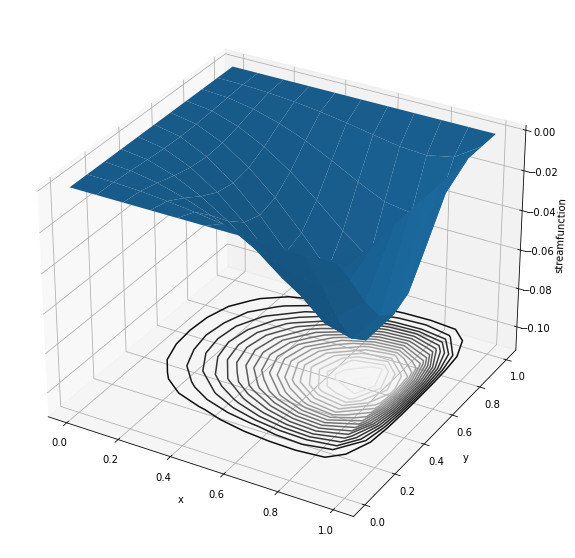

In [6]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

In [7]:
def find_min(z):
    return np.unravel_index(z.argmin(), z.shape)

In [8]:
# Min location
min_location = find_min(psi)
min_location, (x_grid[min_location], y_grid[min_location]), psi[min_location]

((5, 8), (0.8, 0.5), -0.07791119833961699)

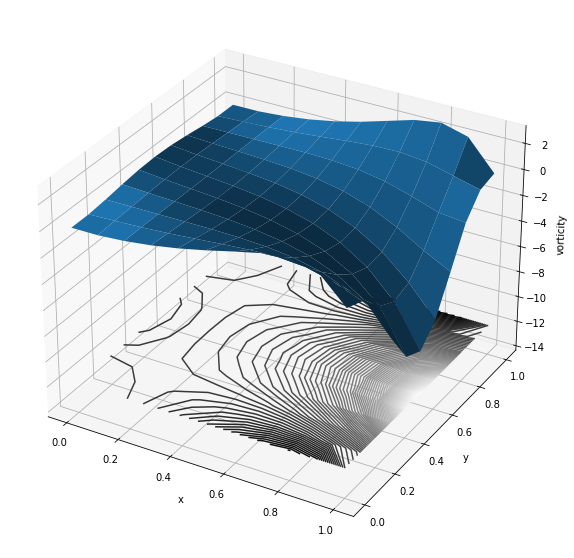

In [9]:
plot(
    x=x_grid, y=y_grid, z=w,
    label="vorticity", levels=80,
    offset=-12, zlim=(-14, 3)
)

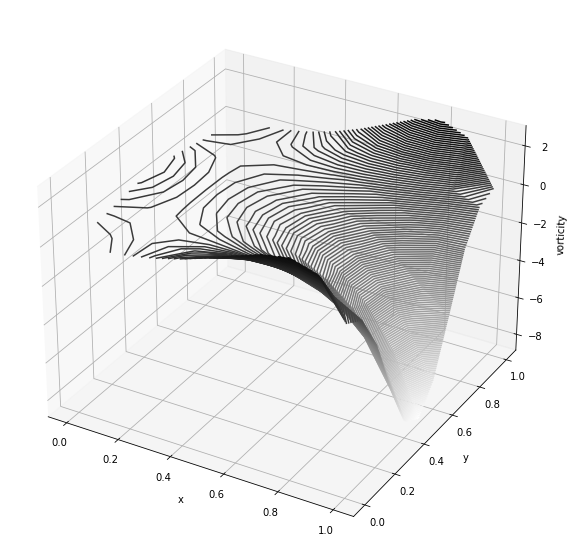

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

ax.contour3D(x_grid, y_grid, w, levels=145, cmap="binary")
ax.set(
    xlabel="x", ylabel="y", zlabel="vorticity",
)

plt.show()

In [11]:
# Min location
min_location = find_min(w)
min_location, (x_grid[min_location], y_grid[min_location]), w[min_location]

((5, 10), (1.0, 0.5), -8.628818063104957)

## Calculating u at middle

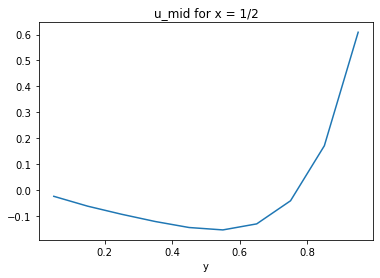

In [12]:
i = nx // 2
u_mid = (psi[i, 1:] - psi[i, :-1]) / h
plt.plot(y_grid[:-1, i] + h / 2, u_mid)
plt.title("u_mid for x = 1/2")
plt.xlabel("y");

## Calculating force

In [13]:
def calculate_force(psi, ny, h):
    # 1st order: (p[i,ny] - 2*p[i,ny-1] + p[i,ny-2])/h;
    # 2nd order:(2*p[i,ny] - 5*p[i,ny-1] + 4*p[i,ny-2] -p[i,ny-3])/h;
    
    return np.sum(
        2 * psi[1:nx - 1, ny - 1] -
        5 * psi[1:nx - 1, ny - 2] +
        4 * psi[1:nx - 1, ny - 3] -
        psi[1:nx - 1, ny - 4]
    ) / h

In [14]:
calculate_force(psi, ny=ny, h=h)

3.402638419034053

# Exercise 1

In [15]:
%%time

# Should be unstable

dpic = 0.025

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 0.525
dt = 0.035

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))

w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)

t=0.03500; w(0.5, 0.5)=0.0
t=0.07000; w(0.5, 0.5)=0.0
t=0.10500; w(0.5, 0.5)=0.0
t=0.14000; w(0.5, 0.5)=0.0
t=0.17500; w(0.5, 0.5)=-0.13931884366753844
t=0.21000; w(0.5, 0.5)=-0.18113994338223866
t=0.24500; w(0.5, 0.5)=-0.2832818989864808
t=0.28000; w(0.5, 0.5)=-0.33024276598809027
t=0.31500; w(0.5, 0.5)=-0.3946990774587819
t=0.35000; w(0.5, 0.5)=-0.4286988571487426
t=0.38500; w(0.5, 0.5)=-0.5160422384090964
t=0.42000; w(0.5, 0.5)=-0.33612442874103154
t=0.45500; w(0.5, 0.5)=-1.0618425191481484
t=0.49000; w(0.5, 0.5)=0.9000825628493532
t=0.52500; w(0.5, 0.5)=-4.158961389523041
CPU times: user 26 ms, sys: 10.3 ms, total: 36.4 ms
Wall time: 29.7 ms


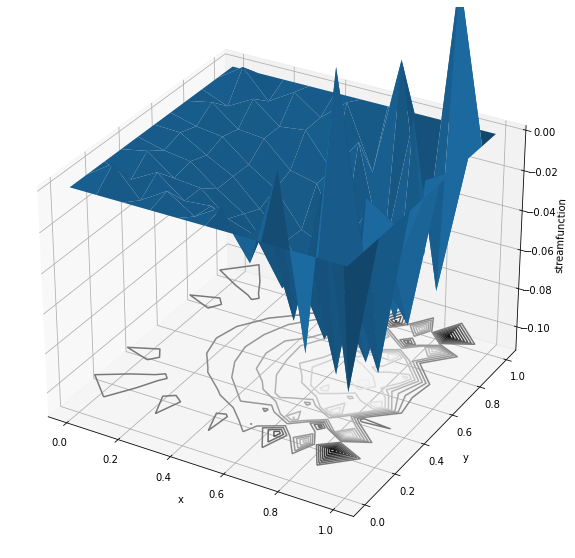

In [16]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

In [17]:
%%time

# Almost stable

dpic = 0.025

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 0.525
dt = 0.03

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))

w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)

t=0.03000; w(0.5, 0.5)=0.0
t=0.06000; w(0.5, 0.5)=0.0
t=0.09000; w(0.5, 0.5)=0.0
t=0.12000; w(0.5, 0.5)=0.0
t=0.15000; w(0.5, 0.5)=-0.06453626408088507
t=0.18000; w(0.5, 0.5)=-0.12702719234818682
t=0.21000; w(0.5, 0.5)=-0.19576682755294986
t=0.24000; w(0.5, 0.5)=-0.257786865692358
t=0.27000; w(0.5, 0.5)=-0.31399006047899014
t=0.30000; w(0.5, 0.5)=-0.36184714007871105
t=0.33000; w(0.5, 0.5)=-0.41126008803277786
t=0.36000; w(0.5, 0.5)=-0.42698282203806104
t=0.39000; w(0.5, 0.5)=-0.5068231713219556
t=0.42000; w(0.5, 0.5)=-0.43383494045854104
t=0.45000; w(0.5, 0.5)=-0.6412446995878762
t=0.48000; w(0.5, 0.5)=-0.3373787666712473
t=0.51000; w(0.5, 0.5)=-0.8913956659186608
t=0.54000; w(0.5, 0.5)=-0.03964578931042306
CPU times: user 36.3 ms, sys: 8.97 ms, total: 45.3 ms
Wall time: 36.4 ms


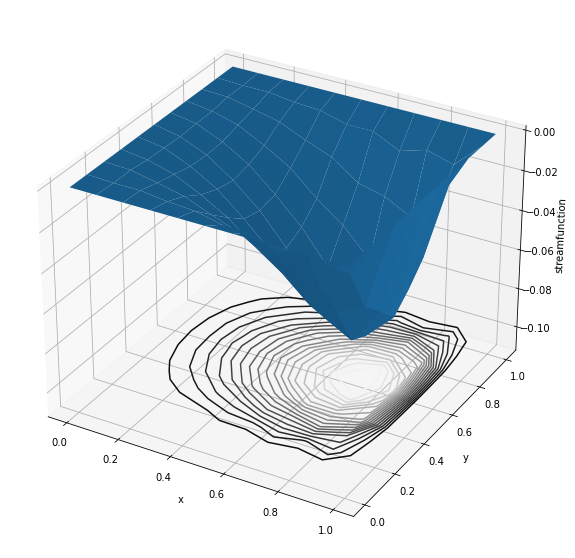

In [18]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

In [19]:
%%time

# Stable

dpic = 0.025

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 3.0
dt = 0.025 # marginal value

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))

w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt)

CPU times: user 222 ms, sys: 855 µs, total: 223 ms
Wall time: 220 ms


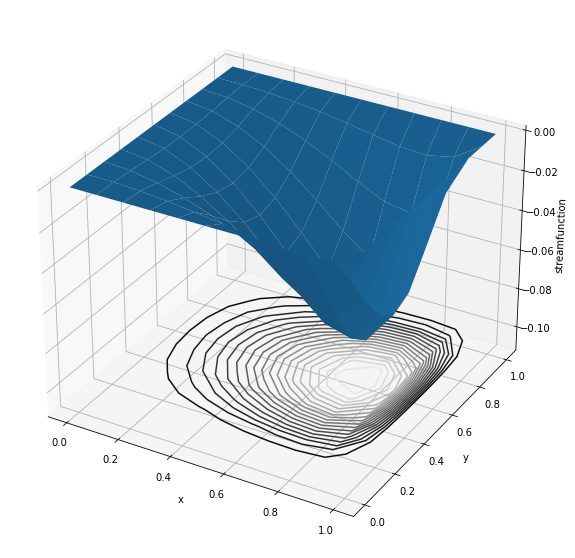

In [20]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

# Exercise 2

In [21]:
%%time


N_to_t = {
    10: [0.02, 0.01, 0.005, 0.0025, 0.001],
    14: [0.01, 0.005, 0.0025, 0.001],
    20: [0.005, 0.0025, 0.001],
}
results = defaultdict(list)

dpic = 0.1

Re = 10 # i.e. mu = 0.1

tfinal = 1.0

for N, dts in N_to_t.items():
    for dt in dts:
        w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt)
        
        results[N].append(w[(N + 1) // 2, (N + 1) // 2])

CPU times: user 11.4 s, sys: 9.33 ms, total: 11.4 s
Wall time: 11.4 s


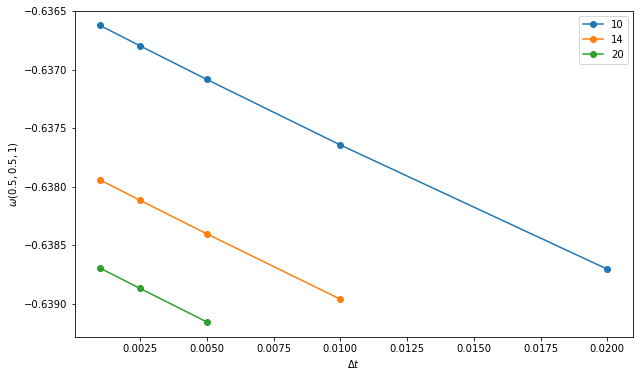

In [22]:
plt.figure(figsize=(10, 6))

for N, omegas in results.items():
    plt.plot(N_to_t[N], omegas, label=N, marker="o")

plt.xlabel(r"$\Delta t$")
plt.ylabel(r"$\omega(0.5, 0.5, 1)$")
plt.legend()
plt.show()

# Exercise 3

In [23]:
%%time

# Stable

dpic = 0.5

N = 40
Re = 10 # i.e. mu = 0.1

tfinal = 3.0

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))

w, psi, omega_mid = solve(N=N, Re=Re, tfinal=tfinal, print_every=dpic)

t=0.50000; w(0.5, 0.5)=-0.5318425795976055
t=1.00000; w(0.5, 0.5)=-0.6392078531937394
t=1.50000; w(0.5, 0.5)=-0.6470209335147183
t=2.00000; w(0.5, 0.5)=-0.6475875194638533
t=2.50000; w(0.5, 0.5)=-0.6476286124379776
t=3.00000; w(0.5, 0.5)=-0.6476315928957449
CPU times: user 29.2 s, sys: 927 ms, total: 30.2 s
Wall time: 30.2 s


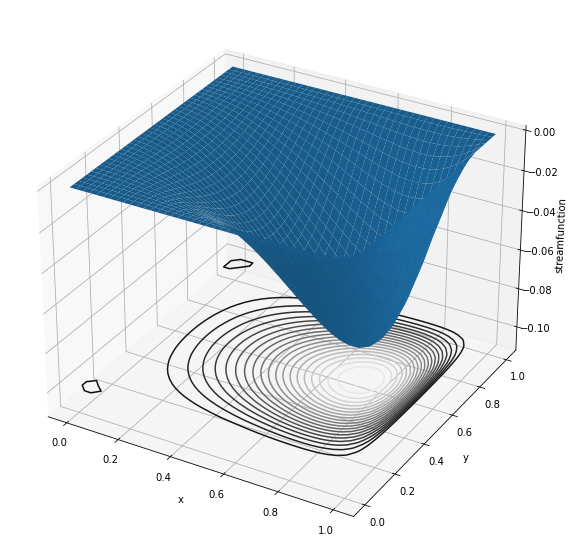

In [24]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

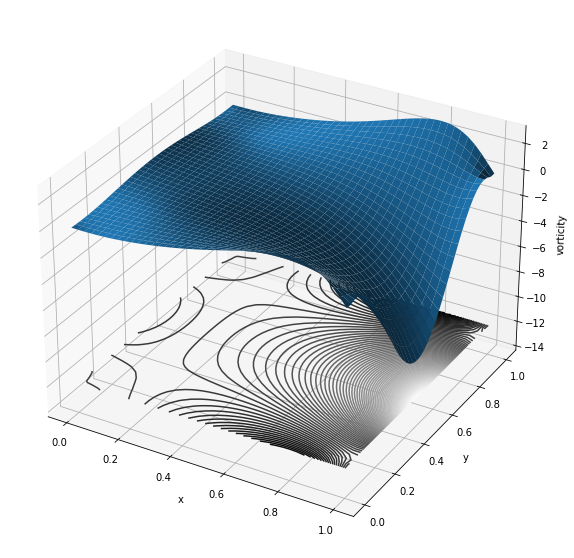

In [25]:
plot(
    x=x_grid, y=y_grid, z=w,
    label="vorticity", levels=80,
    offset=-12, zlim=(-14, 3)
)

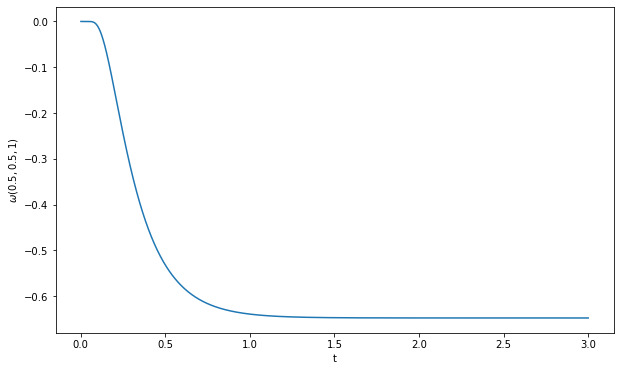

In [26]:
plt.figure(figsize=(10, 6))

dt = 0.2 * Re * h ** 2
time = np.arange(dt, tfinal + dt, dt)
plt.plot(time, omega_mid)

plt.xlabel("t")
plt.ylabel(r"$\omega(0.5, 0.5, 1)$")
plt.show()

In [27]:
# Accurate to 4 sf after
for i in range(50, len(omega_mid)):
    if np.isclose(np.round(np.abs(omega_mid[i] - omega_mid[i - 1]), 4), 0.0):
        print(time[i])
        break

1.0200000000000002


# Exercise 4

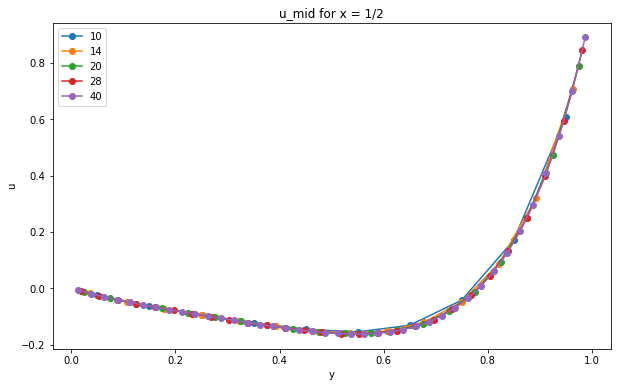

CPU times: user 39.7 s, sys: 52.4 ms, total: 39.8 s
Wall time: 39.7 s


In [28]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

plt.figure(figsize=(10, 6))
for N in [10, 14, 20, 28, 40]:
    w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal)

    i = (N + 1) // 2
    h = 1 / N
    _, y_grid = np.meshgrid(np.linspace(0, 1, N + 1), np.linspace(0, 1, N + 1))
    u_mid = (psi[i, 1:] - psi[i, :-1]) / h
    plt.plot(y_grid[:-1, i] + h / 2, u_mid, label=N, marker="o")
    
    
plt.xlabel("y");
plt.ylabel("u")
plt.title("u_mid for x = 1/2")
plt.legend()

plt.show()

# Exercise 5

In [29]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

N_values = np.array([10, 14, 20, 28, 40])
forces = []
for N in N_values:
    print(N)
    w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal)
    
    force = calculate_force(psi, ny=N + 1, h=1 / N)
    forces.append(force)


10
14
20
28
40
CPU times: user 39.8 s, sys: 34.8 ms, total: 39.8 s
Wall time: 39.8 s


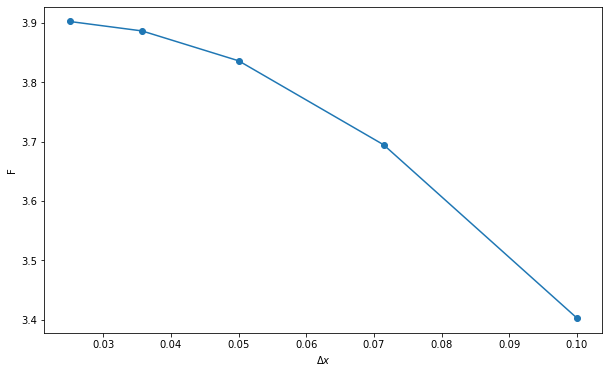

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(1 / N_values, forces, marker="o")
plt.xlabel(r"$\Delta x$")
plt.ylabel("F")

plt.show()

# Exercise 6

In [31]:
# Incorporates both the Poisson problem and time-stepping for the vorticity
# Note that this is a modified version for u=1 at y=1
def modified_solver(N, Re, tfinal, dt=None, print_every=0.0):
    nx = N + 1 # i.e. N = 10
    ny = nx # square domain
    h = 1 / N # h = dx (=dy) = 1 / N; x-size is 1, y-size is ny/nx
    
    w = np.zeros(shape=(nx, ny)) # vorticity
    psi = np.zeros(shape=(nx, ny)) # streamfunction
    dw_dt = np.zeros(shape=(nx, ny)) # dw/dt    
    
    if dt is None:
        dt = np.round(0.2 * Re * h ** 2, 8) # 0.8 * marginal value
    
    omega_mid = []
    
    t = 0
    while t < tfinal:
        # Start by solving the Poisson problem
        psi = sparse_poisson_solver(w)

        
        # Now time-step vorticity

        
        # First calculate BCs to 1st order

        # y = 0. Note U_wall = 0
        w[1:nx - 1, 0] = -((psi[1:nx - 1, 1] - psi[1:nx - 1, 0]) / h - 0) / (0.5 * h)
        # y = 1. Note U_wall = 1 is given here
        w[1:nx - 1, ny - 1] = -(
            1 - (psi[1:nx - 1, ny - 1] - psi[1:nx - 1, ny - 2]) / h
        ) / (0.5 * h)
        
        # x = 0. Note U_wall = 0
        w[0, 1:ny - 1] = (-(psi[1, 1:ny - 1] - psi[0, 1:ny - 1]) / h - 0) / (0.5 * h)
        # x = 1. Note U_wall = 0
        w[nx - 1, 1:ny - 1] = (0 - (-(psi[nx - 1, 1:ny - 1] - psi[nx - 2, 1:ny - 1]) / h)) / (0.5 * h)

        
        # Compute the 2nd order correction to the BCs
        
        # y = 0
        w[1:nx - 1, 0] = (4 * w[1:nx - 1, 0] - w[1:nx - 1, 1]) / 3
        # y = 1
        w[1:nx - 1, ny - 1] = (4 * w[1:nx - 1, ny - 1] - w[1:nx - 1, ny - 2]) / 3
        
        # x = 0
        w[0, 1:ny - 1] = (4 * w[0, 1:ny - 1] - w[1, 1:ny - 1]) / 3

        # x = 1
        w[nx - 1, 1:ny - 1] =(4 * w[nx - 1, 1:ny - 1] - w[nx - 2, 1:ny - 1]) / 3

        # We can now find dw/dt
        dw_dt[1:nx - 1, 1:ny - 1] = (
            -(
                (psi[1:nx - 1, 2:ny] - psi[1:nx - 1, 0:ny - 2]) *
                (w[2:nx, 1:ny - 1] - w[0:nx - 2, 1:ny - 1])
            ) / (4 * h ** 2) + 
            (
                (psi[2:nx, 1:ny - 1] - psi[0:nx - 2, 1:ny - 1]) *
                (w[1:nx - 1, 2:ny] - w[1:nx - 1, 0:ny - 2])
            ) / (4 * h ** 2) + 
            (
                w[2:nx, 1:ny - 1] + w[0:nx - 2, 1:ny - 1] +
                w[1:nx - 1, 2:ny] + w[1:nx - 1, 0:ny - 2] -
                4 * w[1:nx - 1 , 1:ny - 1]
            ) / (Re * h ** 2)
        )

        # Finally, update w
        w[1:nx - 1, 1:ny - 1] = w[1:nx - 1, 1:ny - 1] + dw_dt[1:nx - 1, 1:ny - 1] * dt
        
        # One pass done, increment time
        t = np.round(t + dt, 8)
        
        # Print
        if print_every > 0:
            if 0 <= np.round(t % print_every, 8) < dt:
                print(f"t={t:.5f}; w(0.5, 0.5)={w[nx // 2, ny // 2]}")
        
        omega_mid.append(w[nx // 2, ny // 2])
    
    return w, psi, np.array(omega_mid)


In [32]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

N_values = np.array([10, 14, 20, 28, 40])
forces = []
for N in N_values:
    print(N)
    w, psi, _ = modified_solver(N=N, Re=Re, tfinal=tfinal)
    
    force = calculate_force(psi, ny=N + 1, h=1 / N)
    forces.append(force)

10
14
20
28
40
CPU times: user 39.5 s, sys: 91.3 ms, total: 39.6 s
Wall time: 39.6 s


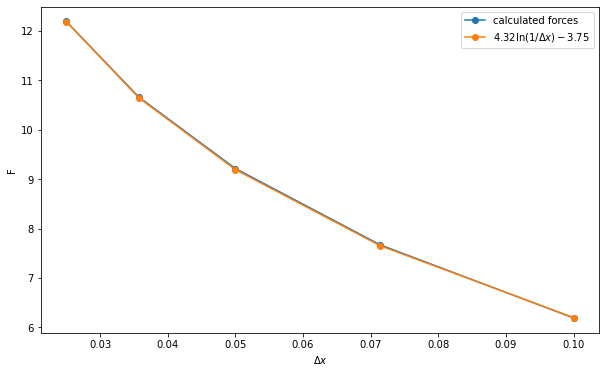

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(1 / N_values, forces, marker="o", label="calculated forces")
plt.plot(1 / N_values, 4.32 * np.log(N_values) - 3.75, marker="o", label=r"$4.32\ln(1/\Delta x) - 3.75$")
plt.xlabel(r"$\Delta x$")
plt.ylabel("F")
plt.legend()

plt.show()